## dataset path

In [1]:
train_dir = 'C:/Users/ROG/OneDrive/桌面/FYP/Dataset/Train_data/train_data_after_washing.csv'
test_dir = 'C:/Users/ROG/OneDrive/桌面/FYP/Dataset/Test_data/test_data_after_washing.csv'

In [3]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

tf.get_logger().setLevel('ERROR') # return ERROR messages, ignore others

ModuleNotFoundError: No module named 'optimization'

## One-hot

In [3]:
def encode_one_hot(ori_dataframe):
    dummies = pd.get_dummies(ori_dataframe.labels)
    res = pd.concat([ori_dataframe, dummies], axis=1)
    return res

## load data

In [4]:
data = pd.read_csv(train_dir)
data = pd.DataFrame(data)
test_data = pd.read_csv(test_dir)
test_data = pd.DataFrame(test_data)
train_data = pd.DataFrame()
val_data = pd.DataFrame()
data = data[["review","rating"]]
test_data = test_data[["review","rating"]]

In [5]:
data.head()

,review,rating
0,"""Abilify changed my life. There is hope. I was...",10
1,"""I have taken anti-depressants for years, with...",10
2,"""I&#039;ve been on every medicine under the su...",10
3,"""I have insomnia, it&#039;s horrible. My story...",10
4,"""Honestly, I have been taking ativan for 2 yea...",6


In [5]:
data['labels'] = data['rating'].map({1 : 1,
                                     2 : 1,
                                     3 : 1,
                                     4 : 1,
                                     5 : 2,
                                     6 : 2,
                                     7 : 2,
                                     8 : 2,
                                     9 : 3,
                                     10 : 3})

In [6]:
test_data['labels'] = test_data['rating'].map({ 1 : 1,
                                                2 : 1,
                                                3 : 1,
                                                4 : 1,
                                                5 : 2,
                                                6 : 2,
                                                7 : 2,
                                                8 : 2,
                                                9 : 3,
                                                10 : 3})

In [7]:
data = data[["review","labels"]]
test_data = test_data[["review","labels"]]

In [8]:
data.head()

,review,labels
0,"""Abilify changed my life. There is hope. I was...",3
1,"""I have taken anti-depressants for years, with...",3
2,"""I&#039;ve been on every medicine under the su...",3
3,"""I have insomnia, it&#039;s horrible. My story...",3
4,"""Honestly, I have been taking ativan for 2 yea...",2


## step sampling

In [8]:
for i in range(1,4):
    condition = data['labels'] == i
    subset = data[condition].sample(frac=0.3)
    val_data = pd.concat([subset, val_data])

train_data = data [~data.index.isin(val_data.index)]

In [10]:
val_data

,review,labels
3800,"""After divorcing my wife of 8 years, and all t...",3
17415,"""After being diagnosed as bipolar from an exce...",3
5833,"""I&#039;ve been living with extreme anxiety, q...",3
16926,"""Started on 20mg about two weeks ago.. anger a...",3
16072,"""One day, out of the blue, I felt lightheaded ...",3
...,...,...
4943,"""After years of being on depression medication...",1
22626,"""Took Viibryd for MDD. Had bad symptoms if I w...",1
31073,"""Itchy beyond belief!""",1
8502,"""Many side effects. I have been trying to wee...",1


In [11]:
train_data

,review,labels
2,"""I&#039;ve been on every medicine under the su...",3
3,"""I have insomnia, it&#039;s horrible. My story...",3
4,"""Honestly, I have been taking ativan for 2 yea...",2
5,"""1 week on Zoloft for anxiety and mood swings....",2
8,"""my gp started me on Venlafaxine yesterday to ...",1
...,...,...
31409,"""Zolpidem does work fast. However, I have a ri...",2
31410,"""I have been taking Cymbalta for 15 months now...",3
31411,"""About 4 years ago I started having early-morn...",2
31412,"""I started taking this medication 10 years ago...",3


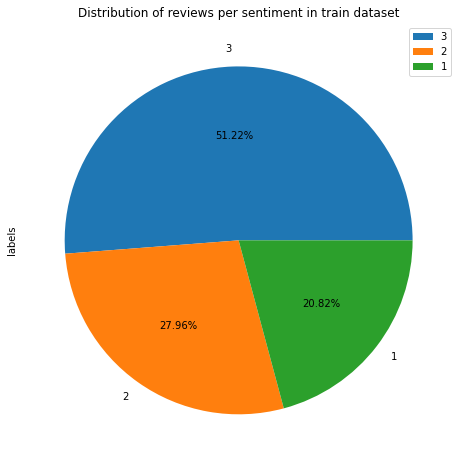

In [13]:
labels = ['3','2','1']
train_data['labels'].value_counts().plot.pie(figsize=(8,8),title="Distribution of reviews per sentiment in train dataset",labels=labels,autopct='%.2f%%')
plt.legend(labels)
plt.gca().set_aspect('equal')

## change labels to one-hot

In [9]:
train_data = encode_one_hot(train_data)
val_data = encode_one_hot(val_data)
test_data = encode_one_hot(test_data)
train_target = train_data[[1,2,3]]
val_target = val_data[[1,2,3]]
test_target = test_data[[1,2,3]]

In [13]:
train_target

,1,2,3
2,0,0,1
3,0,0,1
4,0,1,0
5,0,1,0
8,1,0,0
...,...,...,...
31409,0,1,0
31410,0,0,1
31411,0,1,0
31412,0,0,1


## from datraframes to numpy 

In [10]:
x_train = train_data["review"].to_numpy()
y_train = train_target.to_numpy()
x_val = val_data["review"].to_numpy()
y_val = val_target.to_numpy()
x_test = test_data["review"].to_numpy()
y_test = test_target.to_numpy()

In [15]:
y_train

array([[0, 0, 1],
       [0, 0, 1],
       [0, 1, 0],
       ...,
       [0, 1, 0],
       [0, 0, 1],
       [1, 0, 0]], dtype=uint8)

In [16]:
x_train

array(['"I&#039;ve been on every medicine under the sun (it seems) to manage the hypomania / mania of Bipolar2. Within a few days of starting Lamictal (was on Tegretol) it was as if someone had turned a light on in my head. Is this the way &quot;normal&quot; people think? was one of the first things that struck me. I sleep like a log, have no irritability, almost no anger (other than what would be considered normal). I am able to focus and my creative, impulsive thoughts have decreased enough to be manageable. It&#039;s a God send as I would perennially be in a state of hypo mania, which sounds great, but I was physically and emotionally exhausted. My libido is markedly lower but I wonder if that is perhaps an effect of not being hypo manic. I take 20 mg for anxiety."',
       '"I have insomnia, it&#039;s horrible. My story begins with my PCP prescribing me Prozac to help with intestinal issues, because I was desperate I tried it, I was on it for 3 weeks. Stopped because of insomnia. T

## load bert preprocess and encoder

In [11]:
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/albert_en_base/2'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/albert_en_preprocess/3'

In [12]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [13]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

## define model

In [14]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(3, activation='softmax', name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [29]:
classifier_model = build_classifier_model()

In [24]:
classifier_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

## define loss and metrics

In [25]:
#metrics = tf.keras.metrics.CategoricalAccuracy()

In [30]:
def flood_loss(y_true,y_pred):
    alpha = tf.constant([[2],[4],[3]], dtype=tf.float32) #adjust weight for each label
    gamma = 0.25
    epsilon = 1.e-7
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
    y_t = tf.multiply(y_true, y_pred) + tf.multiply(1-y_true, 1-y_pred)
    ce = -tf.math.log(y_t)
    weight = tf.pow(tf.subtract(1., y_t), gamma)
    fl = tf.matmul(tf.multiply(weight, ce), alpha)
    loss = tf.reduce_mean(fl)
    loss = tf.abs(loss-0.22) + 0.22
    loss = tf.convert_to_tensor(loss)
    return loss
#metrics = tf.keras.metrics.Recall()

## define learning rate, optimizer

In [31]:
epochs = 150
steps_per_epoch = 0
for _ in x_train:
    steps_per_epoch = steps_per_epoch + 1
num_train_steps = steps_per_epoch/8 * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-6
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [32]:
classifier_model.compile(optimizer=optimizer,
                         loss=flood_loss,
                         metrics=["accuracy", tf.keras.metrics.Recall(name='recall')])

## checkpoint, traing recoords and early stopping

In [33]:
checkpoint_path = 'C:/Users/ROG/OneDrive/桌面/FYP/Model/three_way_bert/ckpt/cp.ckpt'
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [34]:
csv_callback = tf.keras.callbacks.CSVLogger(
    'C:/Users/ROG/OneDrive/桌面/FYP/Model/three_way_bert/record.csv', separator=',', append=False
)

In [31]:
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', 
                                               patience=15)

## model reload

In [19]:
classifier_model.load_weights('C:/Users/15972/OneDrive/桌面/FYP/Model/three_way_bert/ckpt/cp.ckpt')

## training and evaluate

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=x_train,
                               y=y_train,
                               validation_data=(x_val,y_val),
                               epochs=150,
                               batch_size=8,
                               callbacks=[cp_callback,csv_callback])

Training model with https://tfhub.dev/tensorflow/albert_en_base/2
Training model with https://tfhub.dev/tensorflow/albert_en_base/2
Epoch 1/150
2750/2750 [==============================] - ETA: 0s - loss: 4.9446 - accuracy: 0.4603 - recall: 0.2724
Epoch 1: saving model to C:/Users/15972/OneDrive/桌面/FYP/Model/three_way_bert/ckpt\cp.ckpt
2750/2750 [==============================] - 1009s 361ms/step - loss: 4.9446 - accuracy: 0.4603 - recall: 0.2724 - val_loss: 4.5545 - val_accuracy: 0.5177 - val_recall: 0.2667
Epoch 2/150
2750/2750 [==============================] - ETA: 0s - loss: 4.3608 - accuracy: 0.5496 - recall: 0.3611
Epoch 2: saving model to C:/Users/15972/OneDrive/桌面/FYP/Model/three_way_bert/ckpt\cp.ckpt
2750/2750 [==============================] - 1046s 380ms/step - loss: 4.3608 - accuracy: 0.5496 - recall: 0.3611 - val_loss: 3.7543 - val_accuracy: 0.6450 - val_recall: 0.4933
Epoch 3/150
2750/2750 [==============================] - ETA: 0s - loss: 3.6575 - accuracy: 0.6629 - rec

2750/2750 [==============================] - 911s 331ms/step - loss: 0.4017 - accuracy: 0.9888 - recall: 0.9873 - val_loss: 3.1294 - val_accuracy: 0.8196 - val_recall: 0.8153
Epoch 44/150
2750/2750 [==============================] - ETA: 0s - loss: 0.3833 - accuracy: 0.9898 - recall: 0.9890
Epoch 44: saving model to C:/Users/15972/OneDrive/桌面/FYP/Model/three_way_bert/ckpt\cp.ckpt
2750/2750 [==============================] - 916s 333ms/step - loss: 0.3833 - accuracy: 0.9898 - recall: 0.9890 - val_loss: 3.0757 - val_accuracy: 0.8182 - val_recall: 0.8137
Epoch 45/150
2750/2750 [==============================] - ETA: 0s - loss: 0.3818 - accuracy: 0.9897 - recall: 0.9888
Epoch 45: saving model to C:/Users/15972/OneDrive/桌面/FYP/Model/three_way_bert/ckpt\cp.ckpt
2750/2750 [==============================] - 932s 339ms/step - loss: 0.3818 - accuracy: 0.9897 - recall: 0.9888 - val_loss: 3.0602 - val_accuracy: 0.8197 - val_recall: 0.8169
Epoch 46/150
2750/2750 [==============================] - E

Epoch 65/150
2750/2750 [==============================] - ETA: 0s - loss: 0.4715 - accuracy: 0.9813 - recall: 0.9801
Epoch 65: saving model to C:/Users/15972/OneDrive/桌面/FYP/Model/three_way_bert/ckpt\cp.ckpt
2750/2750 [==============================] - 895s 325ms/step - loss: 0.4715 - accuracy: 0.9813 - recall: 0.9801 - val_loss: 3.2090 - val_accuracy: 0.8140 - val_recall: 0.8097
Epoch 66/150
2750/2750 [==============================] - ETA: 0s - loss: 0.4205 - accuracy: 0.9855 - recall: 0.9843
Epoch 66: saving model to C:/Users/15972/OneDrive/桌面/FYP/Model/three_way_bert/ckpt\cp.ckpt
2750/2750 [==============================] - 914s 332ms/step - loss: 0.4205 - accuracy: 0.9855 - recall: 0.9843 - val_loss: 3.4066 - val_accuracy: 0.8066 - val_recall: 0.8011
Epoch 67/150
2750/2750 [==============================] - ETA: 0s - loss: 0.4048 - accuracy: 0.9870 - recall: 0.9857
Epoch 67: saving model to C:/Users/15972/OneDrive/桌面/FYP/Model/three_way_bert/ckpt\cp.ckpt
2750/2750 [===============

2750/2750 [==============================] - 890s 323ms/step - loss: 0.2982 - accuracy: 0.9954 - recall: 0.9952 - val_loss: 3.1099 - val_accuracy: 0.8205 - val_recall: 0.8176
Epoch 87/150
2750/2750 [==============================] - ETA: 0s - loss: 0.3019 - accuracy: 0.9956 - recall: 0.9952
Epoch 87: saving model to C:/Users/15972/OneDrive/桌面/FYP/Model/three_way_bert/ckpt\cp.ckpt
2750/2750 [==============================] - 889s 323ms/step - loss: 0.3019 - accuracy: 0.9956 - recall: 0.9952 - val_loss: 3.0956 - val_accuracy: 0.8190 - val_recall: 0.8160
Epoch 88/150
2750/2750 [==============================] - ETA: 0s - loss: 0.2932 - accuracy: 0.9961 - recall: 0.9958
Epoch 88: saving model to C:/Users/15972/OneDrive/桌面/FYP/Model/three_way_bert/ckpt\cp.ckpt
2750/2750 [==============================] - 894s 325ms/step - loss: 0.2932 - accuracy: 0.9961 - recall: 0.9958 - val_loss: 3.1533 - val_accuracy: 0.8219 - val_recall: 0.8186
Epoch 89/150
2750/2750 [==============================] - E

## testing 

In [20]:
loss, accuracy = classifier_model.evaluate(x=x_test,y=y_test,batch_size=8)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

1305/1305 [==============================] - 569s 418ms/step - loss: 0.5136 - recall: 0.8179
Loss: 0.5136268734931946
Accuracy: 0.8179029822349548


## Confusion matrix

In [23]:
y_pred = np.argmax(classifier_model.predict(x_test),axis=1)

327/327 [==============================] - 98s 289ms/step


In [31]:
print(y_pred)

[2 2 0 ... 2 1 2]


In [27]:
y_true = np.argmax(y_test, axis=1)
print(y_true)

[2 2 0 ... 2 2 2]


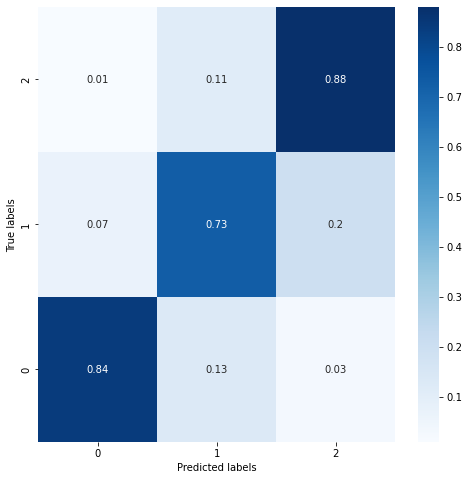

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
con_mat = confusion_matrix(y_true, y_pred)
con_mat_norm = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]     # 归一化
con_mat_norm = np.around(con_mat_norm, decimals=2)
plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_norm, annot=True, cmap='Blues')

plt.ylim(0, 3)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

## visualization

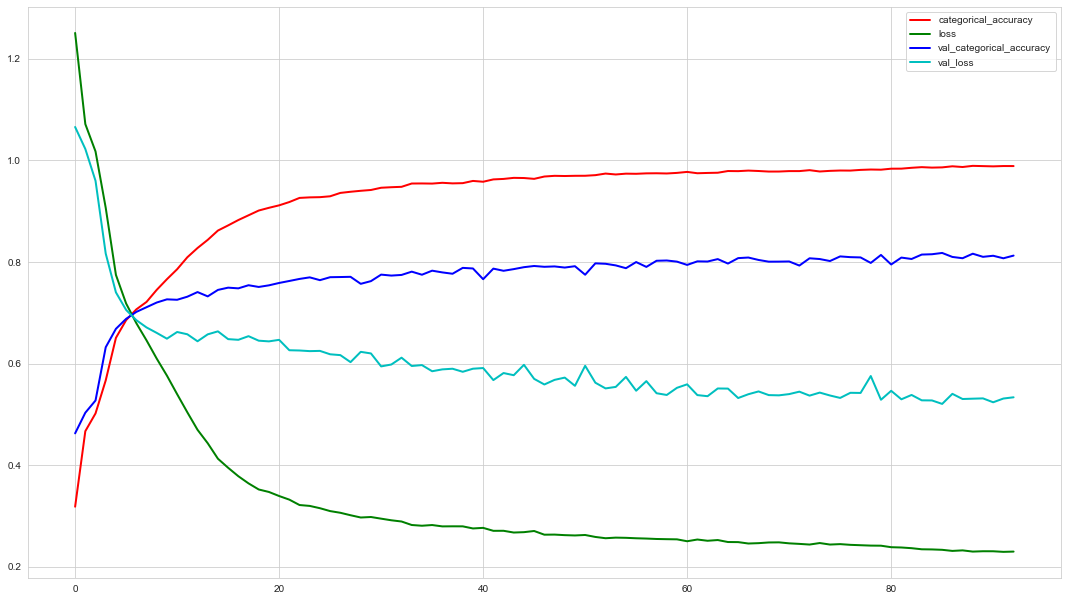

In [38]:
import seaborn as sns
csv_path = 'C:/Users/ROG/OneDrive/桌面/FYP/Model/three_way_bert/record_.csv'
records = pd.read_csv(csv_path)
sns.set_style(style='whitegrid')
labels=['categorical_accuracy','loss','val_categorical_accuracy','val_loss']
plt.plot(records['epoch'],records['categorical_accuracy'], label="categorical_accuracy",color='r', linewidth=2)
plt.plot(records['epoch'],records['loss'], label="loss",color='g', linewidth=2)
plt.plot(records['epoch'],records['val_categorical_accuracy'], label="val_categorical_accuracy",color='b', linewidth=2)
plt.plot(records['epoch'],records['val_loss'], label="val_loss",color='c', linewidth=2)
plt.legend(labels)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

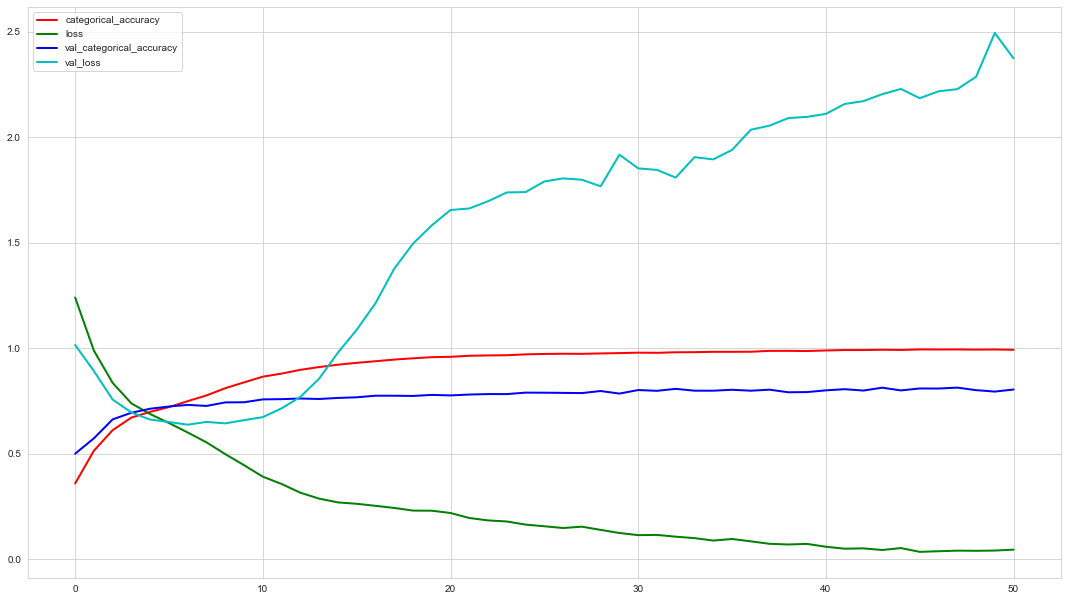

In [40]:
csv_path = 'C:/Users/15972/OneDrive/桌面/FYP/Model/three_way_bert_v1/record.csv'
records = pd.read_csv(csv_path)
sns.set_style(style='whitegrid')
labels=['categorical_accuracy','loss','val_categorical_accuracy','val_loss']
plt.plot(records['epoch'],records['categorical_accuracy'], label="categorical_accuracy",color='r', linewidth=2)
plt.plot(records['epoch'],records['loss'], label="loss",color='g', linewidth=2)
plt.plot(records['epoch'],records['val_categorical_accuracy'], label="val_categorical_accuracy",color='b', linewidth=2)
plt.plot(records['epoch'],records['val_loss'], label="val_loss",color='c', linewidth=2)
plt.legend(labels)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)